# 1. Понимание бизнеса

## 1.1 Цель
Классификация вина на основе результатов физико-химических тестов (входные данные) и сенсорные (выходные данные)

## 1.2 Описание
Набор данных был загружен из репозитория машинного обучения UCI.

Два набора данных относятся к красному и белому вариантам португальского вина "Vinho Verde". Ссылка [Cortez et al., 2009]. Из-за конфиденциальности и логистических проблем доступны только физико-химические (входные данные) и сенсорные (выходные данные) переменные (например, нет данных о сортах винограда, марке вина, отпускной цене вина и т.д.).

Эти наборы данных можно рассматривать как задачи классификации или регрессии. Классы упорядочены и не сбалансированы (например, в мунке больше нормальных вин, чем отличных или плохих). Алгоритмы обнаружения выбросов могут быть использованы для обнаружения нескольких отличных или плохих вин. Кроме того, мы не уверены, все ли входные переменные релевантны. Так что было бы интересно протестировать методы выбора объектов.

Два набора данных были объединены, и несколько значений были удалены случайным образом.

[Описание от Kaggle](https://www.kaggle.com/datasets/rajyellow46/wine-quality)

# 2. Data Understanding

## 2.1 Import Libraries

In [118]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Вспомогательные функции

In [119]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = data.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 2.3 Загрузка данных

In [120]:

data = pd.read_csv( 'winequalityN.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


## 2.4 Статистика и визуализации

In [121]:
data.rename(columns = {'fixed acidity':'фиксированная кислотность',	'volatile acidity':'летучая кислотность',	
                       'citric acid': 'лимонная кислота',	'residual sugar':'остаточный сахар',	'chlorides':'хлориды',	
                       'free sulfur dioxide':'свободный диоксид серы',	'total sulfur dioxide':'общий диоксид серы',	
                       'density':'плотность',	'sulphates':'сульфаты',	'quality':'качество'}, inplace = True)

In [122]:
data.head()

,type,фиксированная кислотность,летучая кислотность,лимонная кислота,остаточный сахар,хлориды,свободный диоксид серы,общий диоксид серы,плотность,pH,сульфаты,alcohol,качество
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Описание переменных**

1 - фиксированная кислотность\
2 - летучая кислотность\
3 - лимонная кислота\
4 - остаточный сахар\
5 - хлориды\
6 - свободный диоксид серы\
7 - общий диоксид серы\
8 - плотность\
9 - pH\
10 - сульфаты\
11 - алкоголь\
Выходная переменная (на основе сенсорных данных):\
12 - качество (оценка от 0 до 10)

[Больше информации на сайте Kaggle](https://www.kaggle.com/datasets/rajyellow46/wine-quality?resource=download)

### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных
Числовая переменная - это переменная со значениями в области целых или действительных чисел, в то время как категориальная переменная - это переменная, которая может принимать одно из ограниченного и обычно фиксированного числа возможных значений, таких как тип крови.

Обратите особое внимание на тип каждой переменной, количество наблюдений и некоторые значения переменных.

Интересным наблюдением может быть, например, максимальный 'остаточный сахар' - 65,8 при среднем - 5,4.

In [123]:
data.describe()

,фиксированная кислотность,летучая кислотность,лимонная кислота,остаточный сахар,хлориды,свободный диоксид серы,общий диоксид серы,плотность,pH,сульфаты,alcohol,качество
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [124]:
# уравновешиваем df данными о красном вине, дублируя имющиеся данные
data_red = data.loc[data['type']=='red']
data = data.append(data_red, ignore_index=True)
data = data.append(data_red, ignore_index=True)
data.groupby(['type']).count()

,фиксированная кислотность,летучая кислотность,лимонная кислота,остаточный сахар,хлориды,свободный диоксид серы,общий диоксид серы,плотность,pH,сульфаты,alcohol,качество
type,,,,,,,,,,,,
red,4791,4794,4794,4797,4797,4797,4797,4797,4791,4791,4797,4797
white,4890,4891,4896,4896,4896,4898,4898,4898,4891,4896,4898,4898


### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

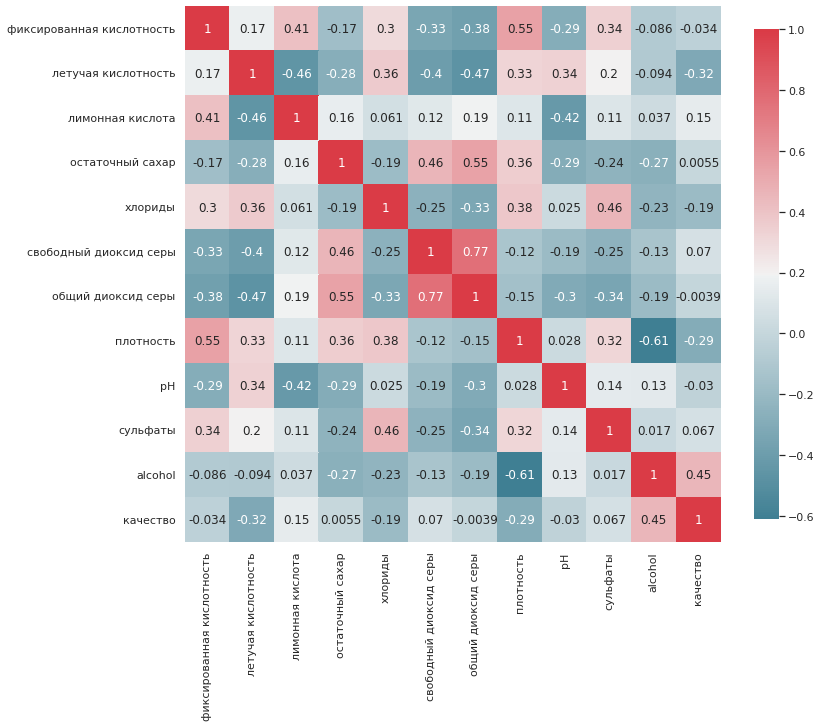

In [142]:
plot_correlation_map( data )

### 2.4.3 Давайте подробнее рассмотрим взаимосвязь между признаками и видом вина
Рассмотрим все признаки поочереди.

In [126]:
import seaborn as sns
sns.set_theme(style="darkgrid")

In [127]:
cols = data.columns

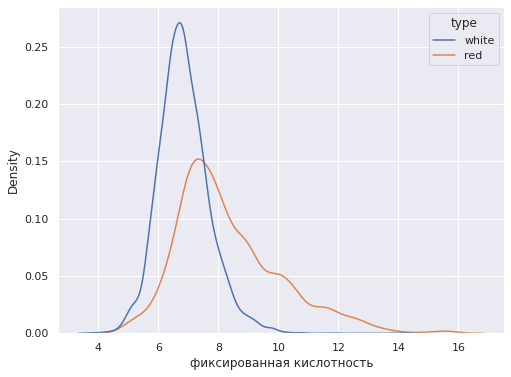

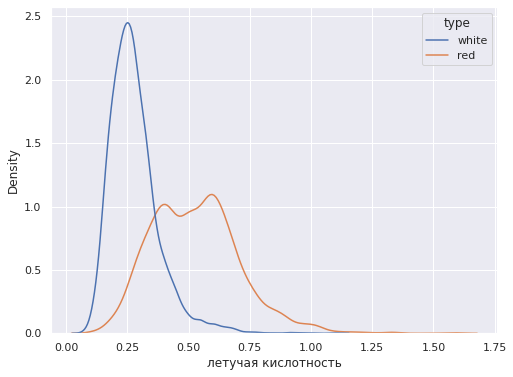

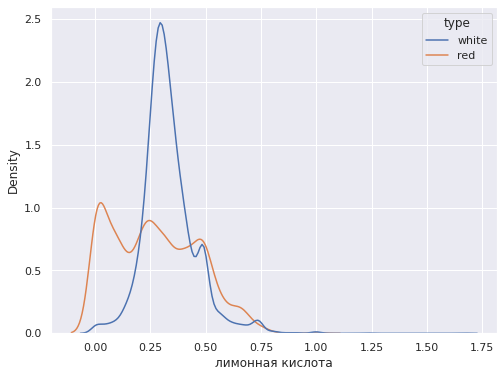

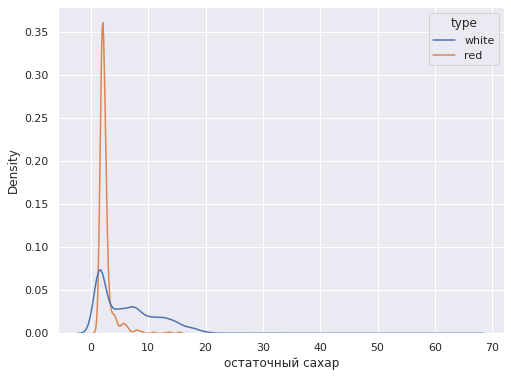

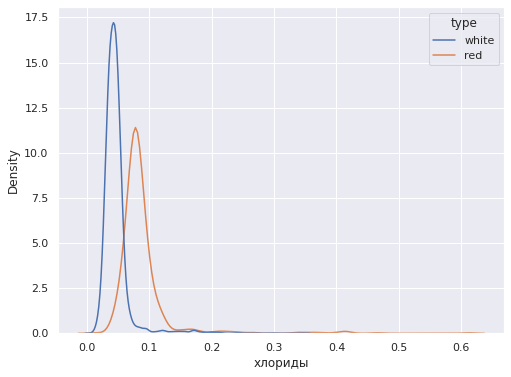

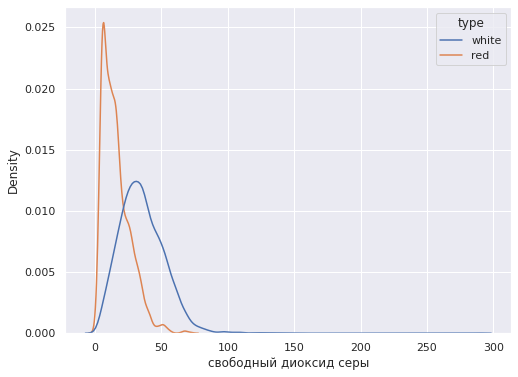

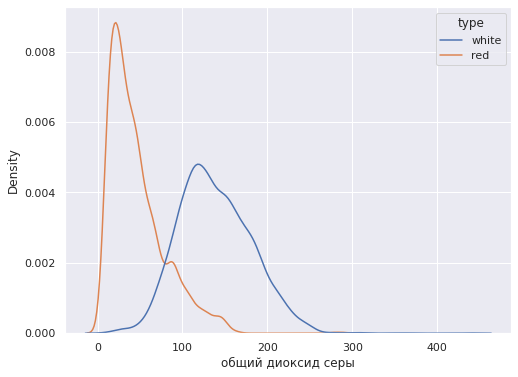

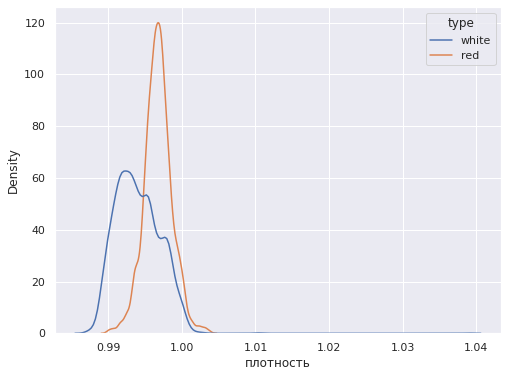

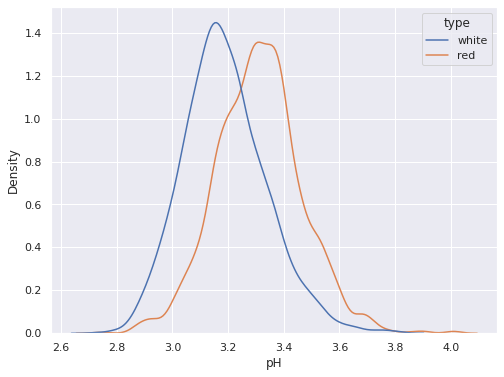

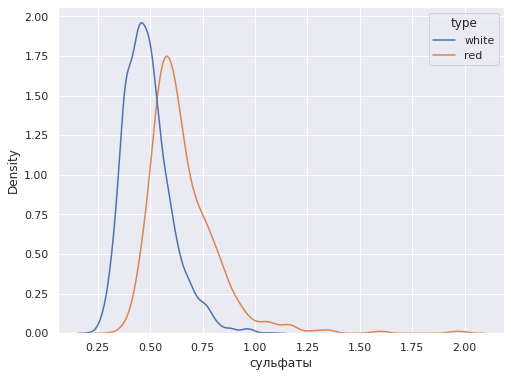

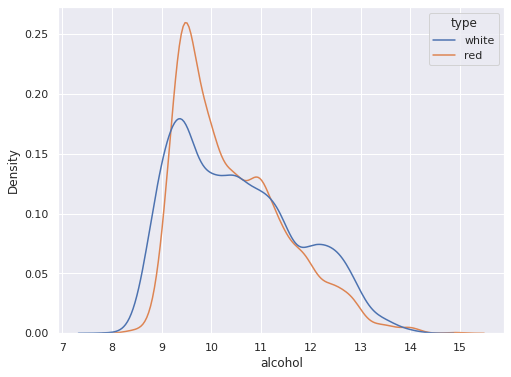

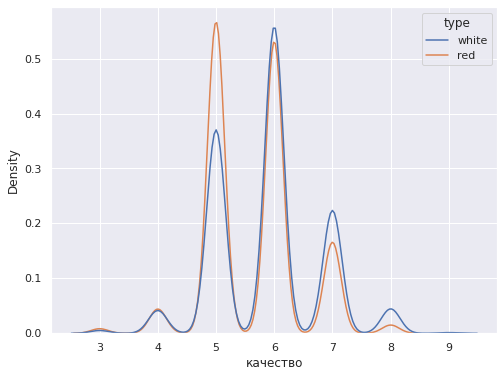

In [128]:
for i in range(len(cols)-1):
    sns.kdeplot( cols[i+1], 
             hue="type", #style="event",
             data=data)
    plt.show()

Рассмотрим графики выше. Различия между видами вина для разных показателей - это то, что будет использоваться для разделения целевой переменной (в данном случае - вид вина) в модели. Если бы две линии были примерно одинаковыми, то это не было бы хорошей переменной для нашей прогностической модели. В основном показатели ведут себя различно.

# 3. Data Preparation

## 3.1 Категориальные переменные должны быть преобразованы в числовые переменные


Переменная 'качество' рассматривается как категориальная переменная. Некоторые из  алгоритмов могут обрабатывать только числовые значения, поэтому нам нужно создать новую (фиктивную) переменную для каждого уникального значения категориальных переменных (OneHotEncoding)

In [129]:
# Create a new variable for every unique value of Pclass
quality = pd.get_dummies( data['качество'] , prefix='качество' )
quality.head()

,качество_3,качество_4,качество_5,качество_6,качество_7,качество_8,качество_9
0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0


## 3.2 Заполнить пропущенные значения в переменных
Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - заполнить пропущенные значения средним по переменной для всех наблюдений в обучающем наборе.

In [130]:
columns = ['фиксированная кислотность', 'летучая кислотность',	'лимонная кислота',	'остаточный сахар',	'хлориды', 'pH',	'сульфаты']

In [131]:
# Create dataset
imputed = pd.DataFrame()

for i in range(len(columns)):
# Fill missing values of Age with the average of Age (mean)
    imputed[ columns[i] ] = data[columns[i]].fillna( data[columns[i]].mean() )

imputed.head()

,фиксированная кислотность,летучая кислотность,лимонная кислота,остаточный сахар,хлориды,pH,сульфаты
0,7.0,0.27,0.36,20.7,0.045,3.00,0.45
1,6.3,0.30,0.34,1.6,0.049,3.30,0.49
2,8.1,0.28,0.40,6.9,0.050,3.26,0.44
3,7.2,0.23,0.32,8.5,0.058,3.19,0.40
4,7.2,0.23,0.32,8.5,0.058,3.19,0.40


In [132]:
# создаем датасет с неиспользованными ни где колонками.
data_ = data[['свободный диоксид серы',	'общий диоксид серы',	'плотность',	'alcohol']]

## 3.4 Сборка финальных датасетов для моделирования

### 3.4.1 Variable selection
Собираем все признаки для формирования итогового датасета. 

In [133]:
full_X = pd.concat( [ imputed , data_ , quality ] , axis=1 )
full_X.head()

,фиксированная кислотность,летучая кислотность,лимонная кислота,остаточный сахар,хлориды,pH,сульфаты,свободный диоксид серы,общий диоксид серы,плотность,alcohol,качество_3,качество_4,качество_5,качество_6,качество_7,качество_8,качество_9
0,7.0,0.27,0.36,20.7,0.045,3.00,0.45,45.0,170.0,1.0010,8.8,0,0,0,1,0,0,0
1,6.3,0.30,0.34,1.6,0.049,3.30,0.49,14.0,132.0,0.9940,9.5,0,0,0,1,0,0,0
2,8.1,0.28,0.40,6.9,0.050,3.26,0.44,30.0,97.0,0.9951,10.1,0,0,0,1,0,0,0
3,7.2,0.23,0.32,8.5,0.058,3.19,0.40,47.0,186.0,0.9956,9.9,0,0,0,1,0,0,0
4,7.2,0.23,0.32,8.5,0.058,3.19,0.40,47.0,186.0,0.9956,9.9,0,0,0,1,0,0,0


### 3.4.2 Создание датасетов

Отделяем данные для обучения и для проверки

In [134]:
# Create all datasets that are necessary to train, validate and test models
X = full_X
y = data['type']
train_valid_X , test_X , train_valid_y , test_y = train_test_split( X , y , train_size = .9, random_state = 42 )

# train_valid_X = full_X
# train_valid_y = data['type']
# # test_X = full_X
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7, random_state = 42 )

print (full_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape )#, test_X.shape)

(9695, 18) (6107, 18) (2618, 18) (6107,) (2618,)


### 3.4.3 Важность признаков
Отбор оптимальных признаков для модели имеет важное значение. Теперь мы попытаемся оценить, какие переменные являются наиболее важными, чтобы сделать прогноз.

1.0


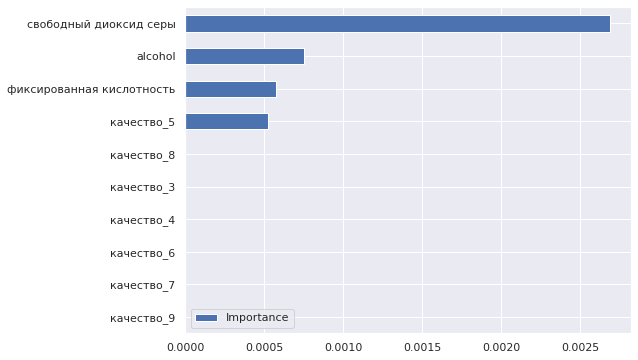

In [135]:
plot_variable_importance(train_X, train_y)

# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели
Хорошей отправной точкой является логистическая регрессия.

In [136]:
model = LogisticRegression()      

## 4.2 Обучение модели

In [137]:
model.fit( train_X , train_y )

LogisticRegression()

# 5. Оценка
Теперь мы собираемся оценить модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [138]:
# Score the model
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.9739643032585558 0.974025974025974


In [139]:
# проверяем модель на тестовых данных
model.score( test_X , test_y )

0.9711340206185567

In [140]:
#Точность меньше, чем на тренировочных, но достойная)

In [143]:
import matplotlib.pyplot as plt, seaborn as sns
from imblearn.over_sampling import SMOTE

from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [264]:
from pandas.core.construction import range_to_ndarray
X = [train_X, valid_X, test_X]
y = [train_y, valid_y, test_y]
d = ['train', 'valid', 'test']
estim = [lr, dt, rf]
name = ['LogisticRegression    ', 'DecisionTreeClassifier', 'RandomForestClassifier']
reg = {}
lr = LogisticRegression(random_state=22)
dt = DecisionTreeClassifier(random_state=22)
rf = RandomForestClassifier(random_state=22, max_features= 4, max_depth= 12)
folds = KFold(n_splits=5, shuffle=True, random_state=45)
for l in range(len(estim)):
    mod = {}
    for i in range(len(d)):
        score = cross_val_score(estimator=estim[l], X=X[i], y=y[i], scoring='accuracy', cv=folds, n_jobs=-1)
        mod[d[i]] = round(score.mean()*100, ndigits=4)
    reg[name[l]] = mod
    print([name[l]], reg[name[l]])
     

['LogisticRegression    '] {'train': 97.4128, 'valid': 97.0583, 'test': 96.1856}
['DecisionTreeClassifier'] {'train': 98.9028, 'valid': 97.2493, 'test': 98.3505}
['RandomForestClassifier'] {'train': 99.8362, 'valid': 99.3503, 'test': 99.5876}
